In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.patches import Ellipse
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

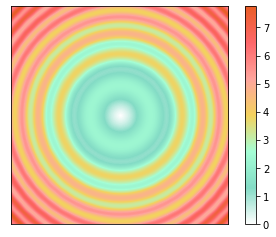

In [2]:
#Some graphics resources 
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp =LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))
hex_list = ["#fffcf2","#ccc5b9","#403d39","#252422","#eb5e28"]
hex_list =["#ffffff","#faf0ca","#f4d35e","#ee964b","#f95738","#eb5e28"]

hex_list =["#ffffff","#84dcc6","#a5ffd6","#f4d35e","#ffa69e","#ff686b","#eb5e28"]
fig, ax = plt.subplots(1,1)
im = ax.imshow(z, cmap=get_continuous_cmap(hex_list))
fig.colorbar(im)
ax.yaxis.set_major_locator(plt.NullLocator()) # remove y axis ticks
ax.xaxis.set_major_locator(plt.NullLocator()) # remove x axis ticks



In [3]:
biomes=xr.open_dataset("~/scripts/efi/biomes_grouped_50km.nc")
#fire activity
activefires=xr.open_dataset("/perm/nen/2020_fire_datacube/activefire_2020_50km.nc")
burned_area=xr.open_dataset("/perm/nen/2020_fire_datacube/2020-C3S-L4_FIRE-BA-OLCI-fv1.1_50km.nc")
#vegetation 
vod=xr.open_dataset("/perm/nen/2020_fire_datacube/2020_VOD_runmean5_50km_timeint.nc")
lai=xr.open_dataset("/perm/nen/2020_fire_datacube/CGLS_LAI_v2_2020_daily_50km.nc")
#Fire weather indices 
fwi=xr.open_dataset("/perm/nen/2020_fire_datacube/FWI_2020_50km.nc")
ffmc=xr.open_dataset("/perm/nen/2020_fire_datacube/FFMC_2020_50km.nc")
dmc=xr.open_dataset("/perm/nen/2020_fire_datacube/DMC_2020_50km.nc")
dc=xr.open_dataset("/perm/nen/2020_fire_datacube/DC_2020_50km.nc")
isi=xr.open_dataset("//perm/nen/2020_fire_datacube/ISI_2020_50km.nc")
bui=xr.open_dataset("/perm/nen/2020_fire_datacube/BUI_2020_50km.nc")

In [ ]:
#fire activity
af=activefires.var98.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
ba=burned_area.burned_area.to_dataframe().reset_index().drop(columns=['time','lat','lon'])

#fire indices
fwi=fwi.fwi.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
ffmc=ffmc.ffmc.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
dmc=dmc.dmc.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
dc=dc.dc.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
isi=isi.isi.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
bui=bui.bui.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
#vegetation 
vod=vod.SM_IDW.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
lai=lai.LAI.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
#biomes
bio=biomes.var1.to_dataframe().reset_index().drop(columns=['time','lat','lon'])


#Looking at the frequency of occurrence between vod/lai and fire weather indices non/considering the fires event 

In [5]:
df=pd.DataFrame()
df["af"]=af.var98
df["ba"]=ba.burned_area
df["fwi"]=fwi.fwi
df["ffmc"]=ffmc.ffmc
df["dc"]=dc.dc
df["dmc"]=dmc.dmc
df["isi"]=isi.isi
df["bui"]=bui.bui
df["lai"]=lai.LAI
df["vod"]=vod.SM_IDW

df["bio"]=np.resize(np.array(bio), df.shape[0])
df.loc[df['fwi']==0]=0.001

df["Bio_Names"]=""
df.loc[df['bio'] ==1, "Bio_Names"] = "Savanna"
df.loc[df['bio'] ==2, "Bio_Names"] = "Agriculture"
df.loc[df['bio'] ==3, "Bio_Names"] = "Forest"

df=df.dropna(axis=0, how='any')

In [6]:
#better to have a linear variable for FWI..transform with log
df['fwi']=np.log(df.fwi)
#the vegetation variable needs to be normalised so we can either use VOD or LAI or any other indicators
#df['vod']=(df.vod)/np.max(df.vod)
#df['lai']=(df.lai)/np.max(df.lai)
(df.lai)

50984       0.666667
50985       2.333333
50986       0.666667
50987       1.766667
50988       1.800000
              ...   
94818258    0.333333
94818266    0.533333
94819149    0.133333
94819855    0.633333
94820574    0.466667
Name: lai, Length: 13296706, dtype: float32

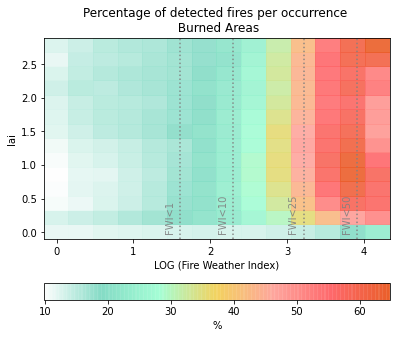

In [40]:
#plt.rcParams['pcolor.shading'] ='flat'
veg='lai'
firetype='ba'
nrow=15
ncol=15
fwisteps=np.linspace(0, 4.5, ncol)
vegsteps=np.linspace(0, 3, nrow)

# all cases 

dft_all=df.copy()
aggdf_all=dft_all.groupby([pd.cut(dft_all["fwi"], fwisteps),
                           pd.cut(dft_all[veg], vegsteps)]).count().drop(columns=[veg,'fwi'])
aggdfreset_all = aggdf_all.reset_index()

aggdfpivot_all=aggdfreset_all.pivot('fwi', veg)
Z_all=aggdfpivot_all['dc'].values

# only cases when a fire occurred 

dft=df.copy()
dft=dft[dft[firetype]>0]

aggdf=dft.groupby([pd.cut(dft["fwi"], fwisteps),
                   pd.cut(dft[veg], vegsteps)]).count().drop(columns=[veg,'fwi'])
aggdfreset = aggdf.reset_index()

aggdfpivot=aggdfreset.pivot('fwi', veg)
Z=aggdfpivot[firetype].values

# resume the X and Y value 
X=aggdfpivot.columns.levels[1].values
X=pd.IntervalIndex(X).left

Y=aggdfpivot.index.values
Y=pd.IntervalIndex(Y).left
# mash grid for plotting 

Xi,Yi = np.meshgrid(X, Y)

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 
current_cmap =get_continuous_cmap(hex_list);
current_cmap.set_bad(color='gray')
cp = ax.pcolormesh(Yi, Xi, 100*(Z.astype(np.float64)/Z_all.astype(np.float64)), 
                   alpha=0.9, shading='auto', cmap=current_cmap);
ax.axvline(np.log(25), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(25)-0.2,0.01,'FWI<25',rotation=90,
        alpha=0.9,color='gray')
ax.axvline(np.log(50), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(50)-0.2,0.01,'FWI<50',rotation=90,
        alpha=0.9,color='gray')
ax.axvline(np.log(10), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(10)-0.2,0.01,'FWI<10',rotation=90,
        alpha=0.9,color='gray')
ax.axvline(np.log(5), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(5)-0.2,0.01,'FWI<1',rotation=90,
        alpha=0.9,color='gray')

# ax.clabel(cp, inline=True, fmt='%1.1f',
#           fontsize=10)
ax.set_title('Percentage of detected fires per occurrence \n Burned Areas')
ax.set_xlabel('LOG (Fire Weather Index)')
ax.set_ylabel(veg)
plt.colorbar(cp, ax=ax, label="%", location='bottom')
plt.savefig('/home/nen/scripts/efi/percentage_fire_occurrence_ba_lai.svg', format='svg', dpi=1200)
plt.show()

In [54]:
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

veg='vod'
firetype='af'
nrow=15
ncol=15
fwisteps=np.linspace(0, 4.5, ncol)
vegsteps=np.linspace(0, 1, nrow)

# all cases 

dft_all=df.copy()
aggdf_all=dft_all.groupby([pd.cut(dft_all["fwi"], fwisteps),
                           pd.cut(dft_all[veg], vegsteps)]).count().drop(columns=[veg,'fwi'])
aggdfreset_all = aggdf_all.reset_index()

aggdfpivot_all=aggdfreset_all.pivot('fwi', veg)
Z_all=aggdfpivot_all['dc'].values

# only cases when a fire occurred 

dft=df.copy()
dft=dft[dft[firetype]>0]

aggdf=dft.groupby([pd.cut(dft["fwi"], fwisteps),
                   pd.cut(dft[veg], vegsteps)]).count().drop(columns=[veg,'fwi'])
aggdfreset = aggdf.reset_index()

aggdfpivot=aggdfreset.pivot('fwi', veg)
Z=aggdfpivot[firetype].values
# resume the X and Y value 
X=aggdfpivot.columns.levels[1].values
X=pd.IntervalIndex(X).left

Y=aggdfpivot.index.values
Y=pd.IntervalIndex(Y).left
# mash grid for plotting 

Xi,Yi = np.meshgrid(X, Y)

# Our function to fit is going to be an exponenet 

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _dfi(M,F, a,b,x0,y0):
    F=1
    x, y = M   
    arr = np.zeros(x.shape)
    arr = F*np.exp( -((x-x0)/a)**2 -((y-y0)/b)**2)
   # arr = 1/(1+F*np.exp( -((x-x0)/a)**2 +((y-y0)/b)**2))
    return arr
#VOD and FWI (AF)
# Fitted parameters:
# [1.         0.40328137 2.30983676 0.63205959 5.84513227]
# RMS residual = 0.0326548626770067

#VOD and FWI (BA)
# Fitted parameters:
#[1.         0.56716912 3.11504565 0.64580504 5.47653683]
#RMS residual = 0.0762256324290762

#LAI and FWI (BA)
#Fitted parameters:
#[1.         2.88346787 4.63542915 1.76583275 7.37171185]
#RMS residual = 0.05902737314947236

#LAI and FWI (AF)
#Fitted parameters:
#[1.         2.64423403 3.70410676 2.10724886 8.25428815]
#RMS residual = 0.027864104485975108

Z_dfi=Z.astype(np.float64)/Z_all.astype(np.float64)
guess_prms = [1, 0.5, 2, 0.5, 6]            
# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((Xi.ravel(), Yi.ravel()))
popt, pcov = curve_fit(_dfi, xdata, Z_dfi.ravel(),guess_prms)
F,a,b,x0,y0 =popt

best_fit = np.zeros(Z_dfi.shape)
Mi=Xi,Yi
best_fit = _dfi(Mi,F,a,b,x0,y0)
print('Fitted parameters:')
print(popt)
rms = np.sqrt(np.mean((Z_dfi - best_fit)**2))
print('RMS residual =', rms)



Fitted parameters:
[1.         0.40327742 2.30983386 0.63205985 5.84512425]
RMS residual = 0.03265486267441476


/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


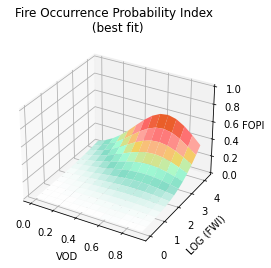

In [69]:
# Plot the 3D figure of the fitted function and the residuals.

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(Xi, Yi,best_fit, cmap=get_continuous_cmap(hex_list))
ax.set_zlim(0,1)
ax.set_title('Fire Occurrence Probability Index \n (best fit)')
ax.set_ylabel('LOG (FWI)')
ax.set_zlabel('FOPI')
ax.set_xlabel('VOD')

plt.savefig('/home/nen/scripts/efi/3Dsurf_bf.svg', format='svg', dpi=1200)
plt.show()

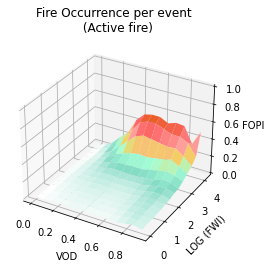

In [68]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(Xi, Yi,Z_dfi, cmap=get_continuous_cmap(hex_list))

ax.set_zlim(0,1)
ax.set_title('Fire Occurrence per event \n (Active fire)')
ax.set_ylabel('LOG (FWI)')
ax.set_zlabel('FOPI')
ax.set_xlabel('VOD')

plt.savefig('/home/nen/scripts/efi/3Dsurf_data.svg', format='svg', dpi=1200)
plt.show()

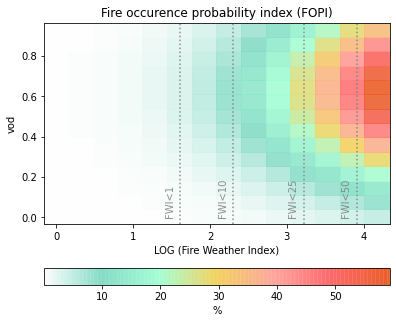

In [60]:
# Plot the test data as a 2D image and the fit as overlaid contours.

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 
current_cmap =get_continuous_cmap(hex_list);
current_cmap.set_bad(color='gray')
cp = ax.pcolormesh(Yi, Xi, 100*(best_fit), 
                   alpha=0.9, shading='auto', cmap=current_cmap);
ax.axvline(np.log(25), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(25)-0.2,0.01,'FWI<25',rotation=90,
        alpha=0.9,color='gray')
ax.axvline(np.log(50), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(50)-0.2,0.01,'FWI<50',rotation=90,
        alpha=0.9,color='gray')
ax.axvline(np.log(10), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(10)-0.2,0.01,'FWI<10',rotation=90,
        alpha=0.9,color='gray')
ax.axvline(np.log(5), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(5)-0.2,0.01,'FWI<1',rotation=90,
        alpha=0.9,color='gray')

# ax.clabel(cp, inline=True, fmt='%1.1f',
#           fontsize=10)
ax.set_title('Fire occurence probability index (FOPI)')
ax.set_xlabel('LOG (Fire Weather Index)')
ax.set_ylabel(veg)
plt.colorbar(cp, ax=ax, label="%", location='bottom')
plt.savefig('/home/nen/scripts/efi/percentage_fire_occurrence_af_vod_best_fit.svg', format='svg', dpi=1200)
plt.show()




<Figure size 432x360 with 0 Axes>

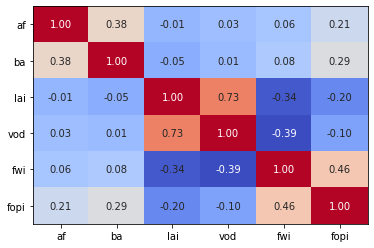

In [77]:
import colorsys
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
#ax = fig.add_axes([left, bottom, width, height]) 


dfver=df.copy()
Ms=dfver['vod'],dfver['fwi']
dfver['fopi']= _dfi(Ms,F,a,b,x0,y0)



dfver=dfver.drop(columns=['bui','bio','ffmc','dc','dmc','isi','Bio_Names'])
cols = dfver.columns.tolist()
cols=['af', 'ba', 'lai', 'vod', 'fwi','fopi']

dfver=dfver[cols]
corr=dfver.corr()
# Fill diagonal and upper half with NaNs
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# corr[mask] = np.nan





fig, ax = plt.subplots()
data = corr.values
heatmap = ax.pcolor(data, cmap=plt.get_cmap('coolwarm'), 
                    vmin=np.nanmin(data), vmax=np.nanmax(data))
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)
ax.invert_yaxis()
row_labels = corr.index
column_labels = corr.columns
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)

def _annotate_heatmap(ax, mesh):
    """
    **Taken from seaborn/matrix.py**
    Add textual labels with the value in each cell.
    """
    mesh.update_scalarmappable()
    xpos, ypos = np.meshgrid(ax.get_xticks(), ax.get_yticks())
    for x, y, val, color in zip(xpos.flat, ypos.flat,
                                mesh.get_array(), mesh.get_facecolors()):
        if val is not np.ma.masked:
            _, l, _ = colorsys.rgb_to_hls(*color[:3])
            text_color = ".15" if l > .5 else "w"
            val = ("{:.2f}").format(val)
            text_kwargs = dict(color=text_color, ha="center", va="center")
            # text_kwargs.update(self.annot_kws)
            ax.text(x, y, val, **text_kwargs)

_annotate_heatmap(ax, heatmap)

plt.savefig('/home/nen/scripts/efi/correlation_matrix.svg', format='svg', dpi=1200)







corr.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1).highlight_null(null_color='#f1f1f1').set_precision(2)
plt.show()

In [ ]:
corr=df.corr().drop(columns)

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
image=(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

#corr.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
df_sa = df[df["bio"] == 1].drop(columns=['bio'])

corr=df_sa.corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

In [ ]:
df_ag = df[df["bio"] == 2].drop(columns=['bio'])

corr=df_ag.corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

corr=df_ag.corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

In [ ]:
df_ft = df[df["bio"] == 3].drop(columns=['bio'])

corr=df_ft.corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))


In [ ]:
df_fire=df.loc[df['ba']>0].drop(columns=['bio'])
corr=df_fire.corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))